In [1]:
!pip install pymysql

In [2]:
import pymysql
import pandas as pd
from shapely import wkt
import geopandas
import matplotlib.pyplot as plt
from pysal.lib import weights
import contextily
import seaborn
from pysal.explore import esda
from splot.esda import plot_moran
from pysal.model import spreg

In [3]:
def conn(host,port,db):
    db_settings = {
        "host": host,
        "port": port,
        "user": "root",
        "password": "",
        "db": db,
        "charset": "utf8",
        "connect_timeout":31536000
    }

    try:
        conn = pymysql.connect(**db_settings)
        print("success connect to bo!!")
    except Exception as ex:
        conn = None
        print(ex)
    return conn

def query(conn,command):
    with conn.cursor() as cursor:
        cursor.execute(command)
        result = cursor.fetchall()
        return result  

-----
# Contiguity Weights空間相鄰權重矩陣

In [4]:
# 資料庫連線
c = conn("house_bo",3306,"bigobject")

success connect to bo!!


In [5]:
# 取出資料放入dataframe
code02 = pd.DataFrame(query(c,"select * from house.area_code2 where city in ('臺北市','新北市')"))
code02 = code02.set_axis(['code2', 'townid', 'town', 'city_id', 'city','u_id',"area",'y','x','geometry','polygon'], axis=1, inplace=False)
code02.head(3)

,code2,townid,town,city_id,city,u_id,area,y,x,geometry,polygon
0,A6501-05,65000010,板橋區,65000,新北市,5,56593.5443,25.032466,121.476122,MULTIPOLYGON (((121.4760850367192 25.033266967...,b'\x00\x00\x00\x00\x01\x06\x00\x00\x00\x01\x00...
1,A6501-06,65000010,板橋區,65000,新北市,6,41802.6326,25.032153,121.470141,MULTIPOLYGON (((121.4710964634274 25.032148007...,b'\x00\x00\x00\x00\x01\x06\x00\x00\x00\x01\x00...
2,A6501-07,65000010,板橋區,65000,新北市,7,49451.5894,25.031605,121.477198,MULTIPOLYGON (((121.4793620134134 25.031974856...,b'\x00\x00\x00\x00\x01\x06\x00\x00\x00\x01\x00...


In [6]:
# dataframe -> geodataframe
code02['geometry'] = geopandas.GeoSeries.from_wkt(code02['geometry'])
gdf = geopandas.GeoDataFrame(code02, geometry='geometry')

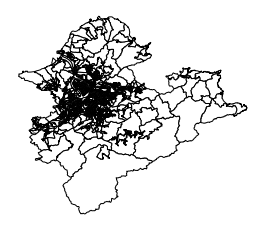

In [7]:
# 畫出邊界
ax = gdf.plot(facecolor='w', edgecolor='k')
ax.set_axis_off()
plt.show()

## 1.Rook:多邊形共用同一個邊

In [8]:
# 空間相鄰矩陣
wr = weights.contiguity.Rook.from_dataframe(gdf)

/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 13 disconnected components.
 There are 11 islands with ids: 327, 830, 1237, 1241, 1288, 1367, 1641, 1647, 1711, 1782, 1830.
  warnings.warn(message)


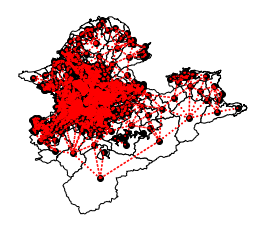

In [9]:
# Set up figure
f,ax = plt.subplots(1,1, subplot_kw=dict(aspect='equal'))
# Plot grid
gdf.plot(facecolor='w', edgecolor='k', ax=ax)

# Plot weights connectivity
wr.plot(gdf, edge_kws=dict(color='r', linestyle=':'), ax =ax)
# Remove axes
ax.set_axis_off()

In [10]:
# 計算非0的數量
wr.nonzero

12088

In [11]:
# 次數分配
pd.DataFrame(wr.histogram).head(15)

,0,1
0,0,11
1,1,6
2,2,45
3,3,238
4,4,519
5,5,604
6,6,390
7,7,215
8,8,87
9,9,44


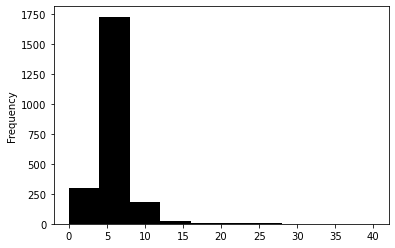

In [12]:
# 繪製直方圖
pd.Series(wr.cardinalities).plot.hist(color='k');

In [13]:
print("連接數："+str(wr.s0))
print("連接密度(連接數/空間數^2 = 40 / 9^2)："+str(round(wr.pct_nonzero,3)))

連接數：12088.0
連接密度(連接數/空間數^2 = 40 / 9^2)：0.239


## 2.Queen:多邊形共用一個或多個點

In [14]:
# 空間相鄰矩陣
wq = weights.contiguity.Queen.from_dataframe(gdf)

/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
 There are 10 islands with ids: 327, 830, 1237, 1288, 1367, 1641, 1647, 1711, 1782, 1830.
  warnings.warn(message)


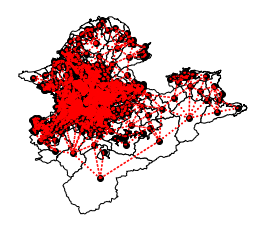

In [15]:
# Set up figure
f,ax = plt.subplots(1,1, subplot_kw=dict(aspect='equal'))
# Plot grid
gdf.plot(facecolor='w', edgecolor='k', ax=ax)

# Plot weights connectivity
wq.plot(gdf, edge_kws=dict(color='r', linestyle=':'), ax =ax)
# Remove axes
ax.set_axis_off()

In [16]:
# 計算非0的數量
wq.nonzero

13366

In [17]:
# 次數分配
pd.DataFrame(wq.histogram).head(15)

,0,1
0,0,10
1,1,3
2,2,36
3,3,145
4,4,398
5,5,526
6,6,467
7,7,279
8,8,171
9,9,83


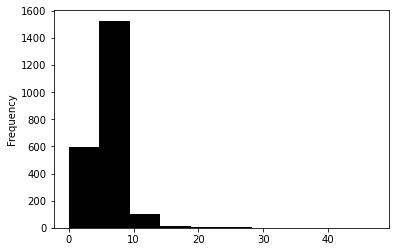

In [18]:
# 繪製直方圖
pd.Series(wq.cardinalities).plot.hist(color='k');

In [19]:
print("連接數："+str(wq.s0))
print("連接密度(連接數/空間數^2 = 40 / 9^2)："+str(round(wq.pct_nonzero,3)))

連接數：13366.0
連接密度(連接數/空間數^2 = 40 / 9^2)：0.264


-----------------
# Spatial Autocorrelation空間自相關

In [20]:
# 資料庫連線
m = conn("house_master",3306,"bigobject")

success connect to bo!!


In [21]:
house_var = [
    'unit_price',      #單價
    'area',            #土地移轉總面積平方公尺
    'year(trans_date) - year(complete_date) as age',     
                       #屋齡
    'shifting_area',   #建物移轉總面積平方公尺
    'pattern_room',    #建物現況格局-房
    'pattern_hall',    #建物現況格局-廳
    'pattern_health',  #建物現況格局-衛
    'building_area'    #主建物面積
]

In [22]:
other_var = [
    'airport',
    'ancestralhall',
    'busstation',
    'carrefour',
    'cleaninginstitution',
    'cleaningteam',
    'costco',
    'firestation',
    'foundation',
    'funeralfacilities',
    'gas_station',
    'hospital',
    'incinerator',
    'incineratorarea',
    'incineratorchimney',
    'lpg',
    'mrtstation',
    'nightmarket',
    'nuclear_powerplant',
    'pharmarcy',
    'policestation',
    'powerplant',
    'pxmart',
    'radio',
    'recyclablesdepot',
    'rtmart',
    'school',
    'shopfamily + shophilife + shopokmart + shopseven as store',
    'simplemart',
    'temple',
    'tymetrostation',
    'waste',
    'wastewater'
]

In [23]:
house_var_n = [v.split(" as ")[1] if " as " in v else v for v in house_var]
other_var_n = [v.split(" as ")[1] if " as " in v else v for v in other_var]

In [24]:
sql = "select code2,"+",".join(house_var) + " from house_buy where city in ('臺北市','新北市') and not transaction_sign in ('車位','土地')  and tgosresaddress <> '找不到指定的門牌地址。'"
sql = "select code2,{} from ({}) group by code2".format(",".join(["avg("+v+") as "+v for v in house_var_n]),sql)
sql = "select code2,{},{},c.geometry as geometry from ({}) a left join (select code2,{} from unified.code2) b on a.code2 = b.code2 inner join house.area_code2 c on a.code2 = c.code2".format(",".join(["a."+v+" as "+v for v in house_var_n]),",".join(["b."+v+" as "+v for v in other_var_n]),sql,','.join(other_var))
sql = "cluster "+ sql + " partition by db in ('108S3','108S4','109S1','109S2','109S3','109S4','110S1','110S2','110S3','110S4')"
data = pd.DataFrame(query(m,sql))

In [25]:
data = data.set_axis(['code2']+house_var_n+other_var_n+['geometry'], axis=1, inplace=False)
data['geometry'] = geopandas.GeoSeries.from_wkt(data['geometry'])
data.head()

,code2,unit_price,area,age,shifting_area,pattern_room,pattern_hall,pattern_health,building_area,airport,...,recyclablesdepot,rtmart,school,store,simplemart,temple,tymetrostation,waste,wastewater,geometry
0,A6308-14,162524.400000,14.470000,28.40000,98.894000,1.200000,1.200000,1.200000,63.842000,0,...,0,0,1,1,1,0,0,0,0,"MULTIPOLYGON (((121.54808 25.00278, 121.54834 ..."
1,A6308-04,139426.000000,86.000000,33.00000,175.720000,5.000000,4.000000,3.000000,133.660000,0,...,1,0,2,1,0,0,0,0,0,"MULTIPOLYGON (((121.59590 25.01491, 121.59716 ..."
2,A6308-26,172030.222222,29.620000,238.00000,139.811111,2.444444,1.666667,1.444444,81.073333,0,...,0,0,0,1,1,0,0,0,0,"MULTIPOLYGON (((121.53962 25.00038, 121.53991 ..."
3,A6308-76,164339.200000,27.420000,428.60000,146.584000,3.000000,1.600000,1.200000,103.748000,0,...,0,0,2,2,0,0,0,0,0,"MULTIPOLYGON (((121.56419 24.98591, 121.56429 ..."
4,A6308-30,212736.849057,20.026792,80.09434,129.923962,2.339623,1.528302,1.245283,67.509811,0,...,1,0,2,2,0,0,0,0,0,"MULTIPOLYGON (((121.55760 24.99923, 121.55798 ..."


In [26]:
db = geopandas.GeoDataFrame(data)
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 21168 entries, 0 to 21167
Data columns (total 43 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   code2                21168 non-null  object  
 1   unit_price           21168 non-null  float64 
 2   area                 21168 non-null  float64 
 3   age                  21168 non-null  float64 
 4   shifting_area        21168 non-null  float64 
 5   pattern_room         21168 non-null  float64 
 6   pattern_hall         21168 non-null  float64 
 7   pattern_health       21168 non-null  float64 
 8   building_area        21168 non-null  float64 
 9   airport              21168 non-null  int64   
 10  ancestralhall        21168 non-null  int64   
 11  busstation           21168 non-null  int64   
 12  carrefour            21168 non-null  int64   
 13  cleaninginstitution  21168 non-null  int64   
 14  cleaningteam         21168 non-null  int64   
 15  costco     

In [27]:
w = weights.contiguity.Rook.from_dataframe(db)

/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  warnings.warn(message)


## 1.Global Autocorrelation

/opt/conda/lib/python3.8/site-packages/contextily/tile.py:632: UserWarning: The inferred zoom level of 27 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)


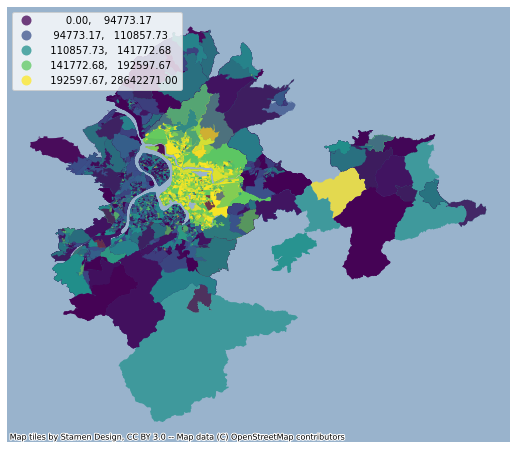

In [28]:
# 單價繪圖
f, ax = plt.subplots(1, figsize=(9, 9))
db.plot(column='unit_price', 
        cmap='viridis', 
        scheme='quantiles',
        k=5, 
        edgecolor='white', 
        linewidth=0., 
        alpha=0.75, 
        legend=True,
        legend_kwds={"loc": 2},
        ax=ax)
contextily.add_basemap(ax, 
                       crs=db.crs, 
                       source=contextily.providers.Stamen.TerrainBackground
                      )
ax.set_axis_off()

In [29]:
# spatial_lag
db['unit_price_lag'] = weights.spatial_lag.lag_spatial(w, db['unit_price'])
db.head()

,code2,unit_price,area,age,shifting_area,pattern_room,pattern_hall,pattern_health,building_area,airport,...,rtmart,school,store,simplemart,temple,tymetrostation,waste,wastewater,geometry,unit_price_lag
0,A6308-14,162524.400000,14.470000,28.40000,98.894000,1.200000,1.200000,1.200000,63.842000,0,...,0,1,1,1,0,0,0,0,"MULTIPOLYGON (((121.54808 25.00278, 121.54834 ...",6.945447e+06
1,A6308-04,139426.000000,86.000000,33.00000,175.720000,5.000000,4.000000,3.000000,133.660000,0,...,0,2,1,0,0,0,0,0,"MULTIPOLYGON (((121.59590 25.01491, 121.59716 ...",1.456640e+07
2,A6308-26,172030.222222,29.620000,238.00000,139.811111,2.444444,1.666667,1.444444,81.073333,0,...,0,0,1,1,0,0,0,0,"MULTIPOLYGON (((121.53962 25.00038, 121.53991 ...",9.303124e+06
3,A6308-76,164339.200000,27.420000,428.60000,146.584000,3.000000,1.600000,1.200000,103.748000,0,...,0,2,2,0,0,0,0,0,"MULTIPOLYGON (((121.56419 24.98591, 121.56429 ...",9.487976e+06
4,A6308-30,212736.849057,20.026792,80.09434,129.923962,2.339623,1.528302,1.245283,67.509811,0,...,0,2,2,0,0,0,0,0,"MULTIPOLYGON (((121.55760 24.99923, 121.55798 ...",7.378292e+06


/opt/conda/lib/python3.8/site-packages/contextily/tile.py:632: UserWarning: The inferred zoom level of 27 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)
/opt/conda/lib/python3.8/site-packages/contextily/tile.py:632: UserWarning: The inferred zoom level of 27 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)


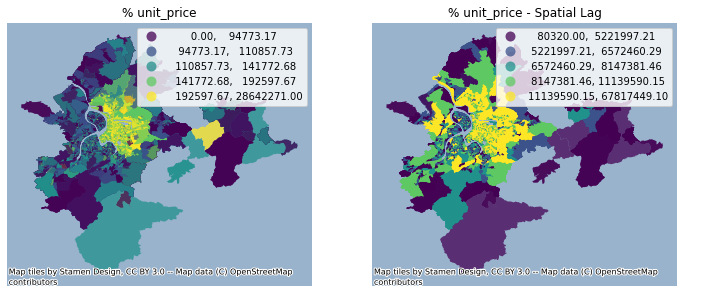

In [30]:
# spatial lag繪圖
f, axs = plt.subplots(1, 2, figsize=(12, 6))
ax1, ax2 = axs

db.plot(column='unit_price', cmap='viridis', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0., alpha=0.75, legend=True, ax=ax1)
ax1.set_axis_off()
ax1.set_title("% unit_price")
contextily.add_basemap(ax1, 
                       crs=db.crs, 
                       source=contextily.providers.Stamen.TerrainBackground,
                       
                      )

db.plot(column='unit_price_lag', cmap='viridis', scheme='quantiles',
        k=5, edgecolor='white', linewidth=0., alpha=0.75, legend=True, ax=ax2)
ax2.set_axis_off()
ax2.set_title("% unit_price - Spatial Lag")
contextily.add_basemap(ax2, 
                       crs=db.crs, 
                       source=contextily.providers.Stamen.TerrainBackground,
                       
                      )

plt.show()

In [32]:
# 單價和單價lag標準化
db['unit_price_std'] = (db['unit_price'] - db['unit_price'].mean()) / db['unit_price'].std()
db['unit_price_lag_std'] = ( db['unit_price_lag'] - db['unit_price_lag'].mean()) / db['unit_price_lag'].std()

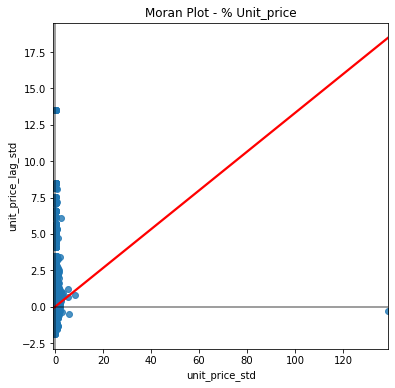

In [33]:
f, ax = plt.subplots(1, figsize=(6, 6))
seaborn.regplot(x='unit_price_std', y='unit_price_lag_std', 
                ci=None, data=db, line_kws={'color':'r'})
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
ax.set_title('Moran Plot - % Unit_price')
plt.show()

In [34]:
# 計算moran's i
moran = esda.moran.Moran(db['unit_price'], w)
moran.I

0.05300917624484929

In [35]:
# empirical p-value:夠小的p-vale允許拒絕地圖是隨機的假設
moran.p_sim

0.001

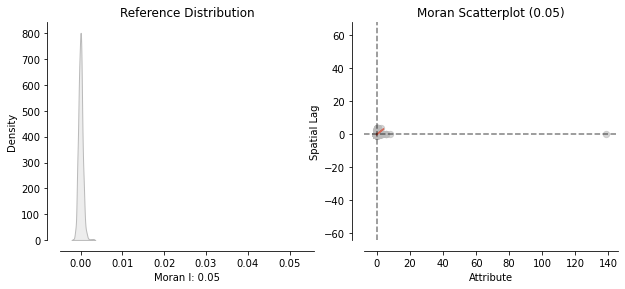

In [36]:
plot_moran(moran);

## 2.Local Autocorrelation

In [37]:
db['w_unit_price'] = weights.spatial_lag.lag_spatial(w, db['unit_price'])

In [38]:
db['w_unit_price_std'] = ( db['w_unit_price'] - db['unit_price'].mean() ) / db['unit_price'].std()

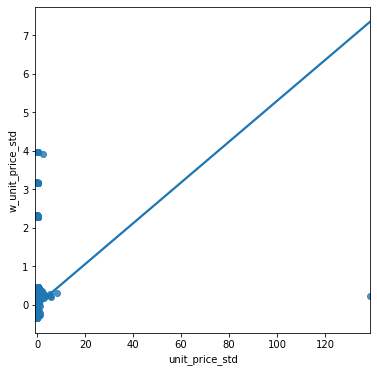

In [39]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(x='unit_price_std', y='w_unit_price_std', data=db, ci=None)
# Display
plt.show()

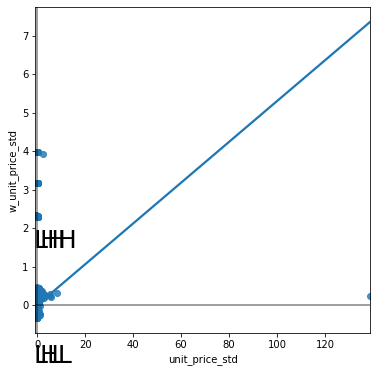

In [40]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(x='unit_price_std', y='w_unit_price_std', data=db, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Add text labels for each quadrant
plt.text(1, 1.5, "HH", fontsize=25)
plt.text(1, -1.5, "HL", fontsize=25)
plt.text(-1.5, 1.5, "LH", fontsize=25)
plt.text(-1.5, -1.5, "LL", fontsize=25)
# Display
plt.show()

In [41]:
# 計算LISA(因為有孤島所以沒辦法算)
lisa = esda.moran.Moran_Local(db['unit_price'], w)

-----------------
# 空間迴歸模型

## 1.Non-spatial regression

In [42]:
dep_var = 'unit_price'
ind_var = []
for v in house_var_n:
    if v != dep_var:
        ind_var.append(v)
ind_var = ind_var + other_var_n

In [43]:
# Fit OLS model
m1 = spreg.OLS(
    # Dependent variable
    data[[dep_var]].values, 
    # Independent variables
    data[ind_var].values,
    # Dependent variable name
    name_y=dep_var, 
    # Independent variable name
    name_x=ind_var
)
print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :  unit_price                Number of Observations:       21168
Mean dependent var  : 143117.2752                Number of Variables   :          39
S.D. dependent var  : 205269.5696                Degrees of Freedom    :       21129
R-squared           :      0.0141
Adjusted R-squared  :      0.0124
Sum squared residual:879281775240459.500                F-statistic           :      7.9693
Sigma-square        :41614926179.207                Prob(F-statistic)     :   1.243e-42
S.E. of regression  :  203997.368                Log likelihood        : -288813.628
Sigma-square ML     :41538254688.230                Akaike info criterion :  577705.255
S.E of regression ML: 203809.3587                Schwarz criterion     :  578015.705

----------------------------------------------------------------

## 2.空間延遲模型(spatial lag model, SLM)

In [44]:
# Fit spatial lag model with `spreg` 
# (GMM estimation)
m2 = spreg.GM_Lag(
    # Dependent variable
    db[[dep_var]].values, 
    # Independent variables
    db[ind_var].values,
    # Spatial weights matrix
    w=w, 
    # Dependent variable name
    name_y=dep_var, 
    # Independent variables names
    name_x=ind_var
)

In [45]:
print(m2.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :  unit_price                Number of Observations:       21168
Mean dependent var  : 143117.2752                Number of Variables   :          40
S.D. dependent var  : 205269.5696                Degrees of Freedom    :       21128
Pseudo R-squared    :      0.0442
Spatial Pseudo R-squared:  0.0369

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT    17197.3470057    9041.7340242       1.9019966       0.0571716
                area       9.2321380       4.8787365       1.8923215       0.0584482
                 age      10.5465095       5.1312863      

In [46]:
# Build full table of regression coefficients
pd.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        'Coeff.': m2.betas.flatten(),
        # Pull out and flatten standard errors
        'Std. Error': m2.std_err.flatten(),
        # Pull out P-values from t-stat object
        'P-Value': [i[1] for i in m2.z_stat]
    },
    index=m2.name_z
# Round to four decimals
).round(4)

,Coeff.,Std. Error,P-Value
CONSTANT,17197.3470,9041.7340,0.0572
area,9.2321,4.8787,0.0584
age,10.5465,5.1313,0.0398
shifting_area,5.7787,14.7528,0.6953
pattern_room,-9539.1817,2846.6127,0.0008
pattern_hall,-2185.8050,4002.2232,0.5850
pattern_health,9325.8925,3677.5493,0.0112
building_area,-5.7142,25.9374,0.8256
ancestralhall,183.5646,12013.5252,0.9878
busstation,3.8503,45.6713,0.9328


## 3.空間誤差模型(spatial error model, SEM)

In [1]:
# Fit spatial error model with `spreg` 
# (GMM estimation allowing for heteroskedasticity)
m3 = spreg.GM_Error_Het(
    # Dependent variable
    db[[dep_var]].values, 
    # Independent variables
    db[ind_var].values,
    # Spatial weights matrix
    w=w, 
    # Dependent variable name
    name_y=dep_var, 
    # Independent variables names
    name_x=ind_var
)

NameError: name 'spreg' is not defined

In [ ]:
# Build full table of regression coefficients
pandas.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        'Coeff.': m3.betas.flatten(),
        # Pull out and flatten standard errors
        'Std. Error': m3.std_err.flatten(),
        # Pull out P-values from t-stat object
        'P-Value': [i[1] for i in m3.z_stat]
    },
    index=m7.name_x
# Subset for lambda parameter and round to
# four decimals
).reindex(['lambda']).round(4)